# Heart Attack Risk Prediction Model
# (CardioPredict)

## Project Overview
This notebook implements a machine learning model to predict whether a person has a risk of heart attack based on various health parameters.

## Step 1: Import Required Libraries

In [53]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve

# ML Algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
plt.style.use('ggplot')

## Step 2: Load and Explore Data

In [54]:
df = pd.read_csv('heart.csv')

print("Dataset Shape:", df.shape)
print("\nFirst 5 rows:")
df.head()

Dataset Shape: (918, 12)

First 5 rows:


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [55]:
print("Dataset Info:")
df.info()
print("\n" + "="*50)
print("\nStatistical Summary:")
df.describe()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


Statistical Summary:


,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


In [56]:
# Check for missing values
print("Missing Values:")
print(df.isnull().sum())

# Check for duplicate rows
print("\n" + "="*50)
print("\nDuplicate Rows:", df.duplicated().sum())

Missing Values:
Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64


Duplicate Rows: 0


## Step 3: Exploratory Data Analysis (EDA)

<Axes: xlabel='HeartDisease'>

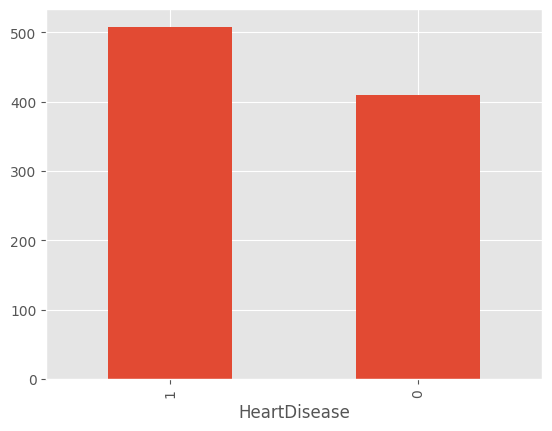

In [57]:
df['HeartDisease'].value_counts().plot(kind = 'bar')

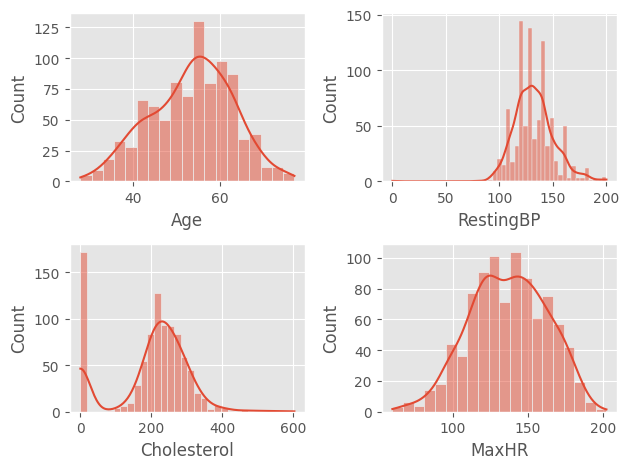

In [58]:
def plotting(col,num):
    plt.subplot(2,2,num)
    sns.histplot(df[col],kde = True)

plotting("Age",1)
plotting("RestingBP",2)
plotting("Cholesterol",3)
plotting("MaxHR",4)

plt.tight_layout()

In [59]:
cholesterol_mean = df.loc[df['Cholesterol'] != 0, 'Cholesterol'].mean()

# Step 2: Replace 0s with the calculated mean
df['Cholesterol'] = df['Cholesterol'].replace(0, cholesterol_mean)

# Optional: Round to 2 decimal places (if needed)
df['Cholesterol'] = df['Cholesterol'].round(2)

In [60]:
resting_bp_mean = df.loc[df['RestingBP'] != 0, 'RestingBP'].mean()

df['RestingBP'] = df['RestingBP'].replace(0, resting_bp_mean)

df['RestingBP'] = df['RestingBP'].round(2)

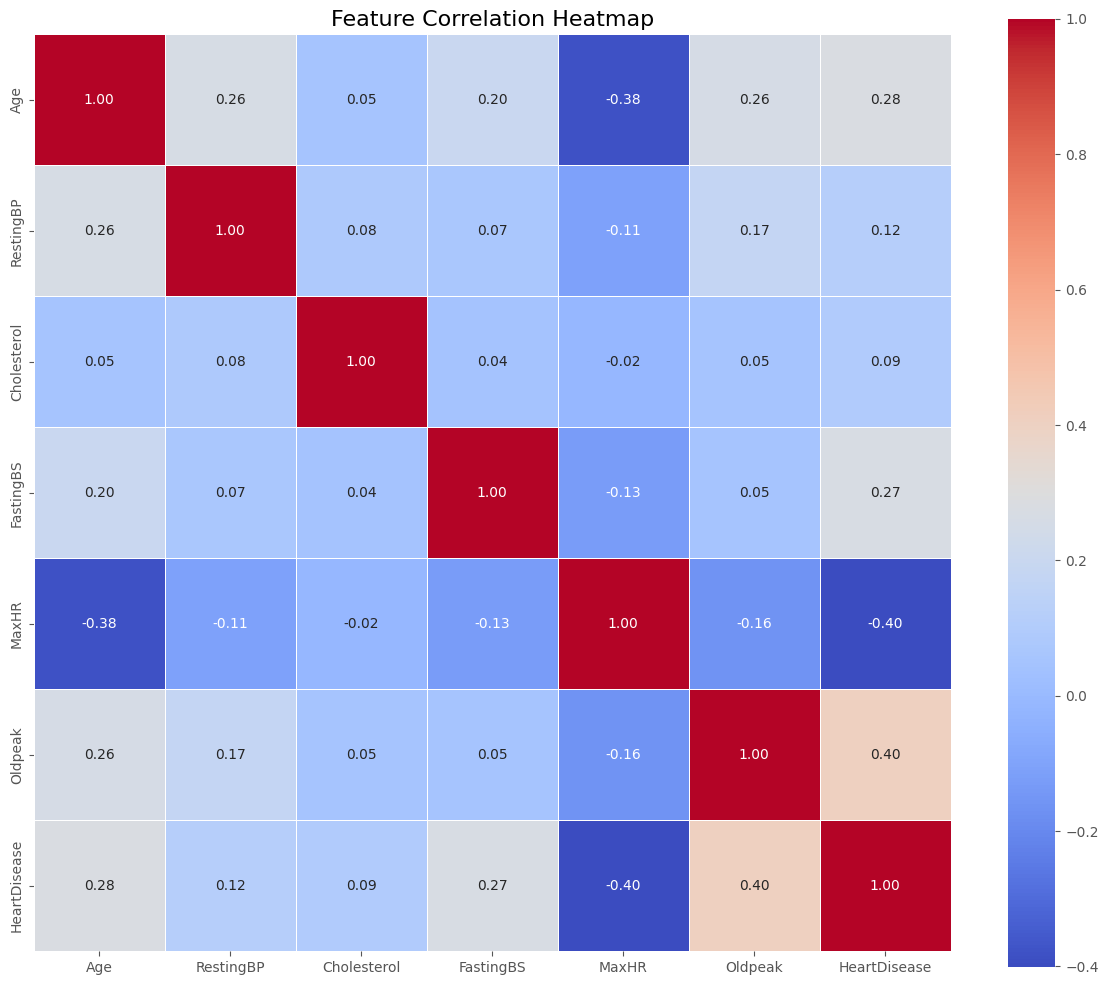

In [61]:
# Correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(numeric_only=True), annot=True, fmt='.2f', cmap='coolwarm', 
            square=True, linewidths=0.5)
plt.title('Feature Correlation Heatmap', fontsize=16)
plt.tight_layout()
plt.show()

## Step 4: Data Preprocessing

In [62]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140.0,289.0,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160.0,180.0,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130.0,283.0,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138.0,214.0,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150.0,195.0,0,Normal,122,N,0.0,Up,0


In [63]:
df_encoded = pd.get_dummies(df,drop_first=True)
df_encoded.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
0,40,140.0,289.0,0,172,0.0,0,True,True,False,False,True,False,False,False,True
1,49,160.0,180.0,0,156,1.0,1,False,False,True,False,True,False,False,True,False
2,37,130.0,283.0,0,98,0.0,0,True,True,False,False,False,True,False,False,True
3,48,138.0,214.0,0,108,1.5,1,False,False,False,False,True,False,True,True,False
4,54,150.0,195.0,0,122,0.0,0,True,False,True,False,True,False,False,False,True


In [64]:
df_encoded = df_encoded.astype(int)
df_encoded.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0,0,1,1,0,0,1,0,0,0,1
1,49,160,180,0,156,1,1,0,0,1,0,1,0,0,1,0
2,37,130,283,0,98,0,0,1,1,0,0,0,1,0,0,1
3,48,138,214,0,108,1,1,0,0,0,0,1,0,1,1,0
4,54,150,195,0,122,0,0,1,0,1,0,1,0,0,0,1


In [65]:
X = df_encoded.drop('HeartDisease', axis=1)
y = df_encoded['HeartDisease']

## Step 5: Train-Test Split

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                      random_state=42, stratify=y)

In [67]:
# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Step 6: Model Training (Multiple Algorithms)

In [68]:
# Define models
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(n_estimators=100),
    'Gradient Boosting': GradientBoostingClassifier(),
    'SVM': SVC(probability=True),
    'KNN': KNeighborsClassifier()
}

# Train all models and store results
results = {}

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train_scaled, y_train)
    results[name] = model
    print(f" {name} trained successfully!")

print("\nAll models trained!")

Training Logistic Regression...
 Logistic Regression trained successfully!
Training Decision Tree...
 Decision Tree trained successfully!
Training Random Forest...
 Random Forest trained successfully!
Training Gradient Boosting...
 Gradient Boosting trained successfully!
Training SVM...
 SVM trained successfully!
Training KNN...
 KNN trained successfully!

All models trained!


## Step 7: Model Evaluation & Comparison

In [69]:
# Evaluate all models
evaluation_results = []

for name, model in results.items():
    # Predictions
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    evaluation_results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    })

In [70]:
# Create comparison dataframe
comparison_df = pd.DataFrame(evaluation_results)
comparison_df = comparison_df.sort_values('Accuracy', ascending=False)
print("\n" + "="*80)
print("MODEL PERFORMANCE COMPARISON")
print("="*80)
print(comparison_df.to_string(index=False))
print("="*80)


MODEL PERFORMANCE COMPARISON
              Model  Accuracy  Precision   Recall  F1-Score
                KNN  0.885870   0.885714 0.911765  0.898551
Logistic Regression  0.875000   0.883495 0.892157  0.887805
  Gradient Boosting  0.869565   0.882353 0.882353  0.882353
                SVM  0.864130   0.859813 0.901961  0.880383
      Random Forest  0.858696   0.865385 0.882353  0.873786
      Decision Tree  0.766304   0.817204 0.745098  0.779487


In [71]:
# Get best model
best_model_name = comparison_df.iloc[0]['Model']
best_model = results[best_model_name]

print(f"\nBest Model: {best_model_name}")
print(f"Accuracy: {comparison_df.iloc[0]['Accuracy']:.4f}")

# Detailed classification report for best model
y_pred_best = best_model.predict(X_test_scaled)
print("\n" + "="*80)
print(f"DETAILED CLASSIFICATION REPORT - {best_model_name}")
print("="*80)
print(classification_report(y_test, y_pred_best, target_names=['No Risk', 'Risk']))


Best Model: KNN
Accuracy: 0.8859

DETAILED CLASSIFICATION REPORT - KNN
              precision    recall  f1-score   support

     No Risk       0.89      0.85      0.87        82
        Risk       0.89      0.91      0.90       102

    accuracy                           0.89       184
   macro avg       0.89      0.88      0.88       184
weighted avg       0.89      0.89      0.89       184



## Step 8: Save the Final Model

In [72]:
# Save the best model and scaler
import pickle

# Save model
with open('cardio_prediction_model.pkl', 'wb') as file:
    pickle.dump(best_model, file)

# Save scaler
with open('scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

## Step 9: Make Predictions on New Data

In [73]:
# Example: Prediction function
def predict_heart_attack_risk(features):
    """
    Predict heart attack risk for new patient data
    
    Parameters:
    features: array-like or list of feature values
    
    Returns:
    prediction: 0 (No Risk) or 1 (Risk)
    probability: probability of heart attack risk
    """
    # Scale features
    features_scaled = scaler.transform([features])
    
    # Make prediction
    prediction = best_model.predict(features_scaled)[0]
    probability = best_model.predict_proba(features_scaled)[0][1]
    
    result = "Risk of Heart Attack" if prediction == 1 else "No Risk"
    
    return {
        'prediction': result,
        'risk_probability': f"{probability*100:.2f}%",
        'confidence': f"{max(probability, 1-probability)*100:.2f}%"
    }

# Test with a sample from test set
sample_index = 1
sample_features = X_test.iloc[sample_index].values
actual_label = "Risk" if y_test.iloc[sample_index] == 1 else "No Risk"

result = predict_heart_attack_risk(sample_features)

print("\n" + "="*80)
print("SAMPLE PREDICTION")
print("="*80)
print(f"Features: {sample_features}")
print(f"Actual: {actual_label}")
print(f"Predicted: {result['prediction']}")
print(f"Risk Probability: {result['risk_probability']}")
print(f"Confidence: {result['confidence']}")
print("="*80)


SAMPLE PREDICTION
Features: [ 58 132 224   0 173   3   1   0   1   0   0   0   0   0   1]
Actual: Risk
Predicted: No Risk
Risk Probability: 40.00%
Confidence: 60.00%
